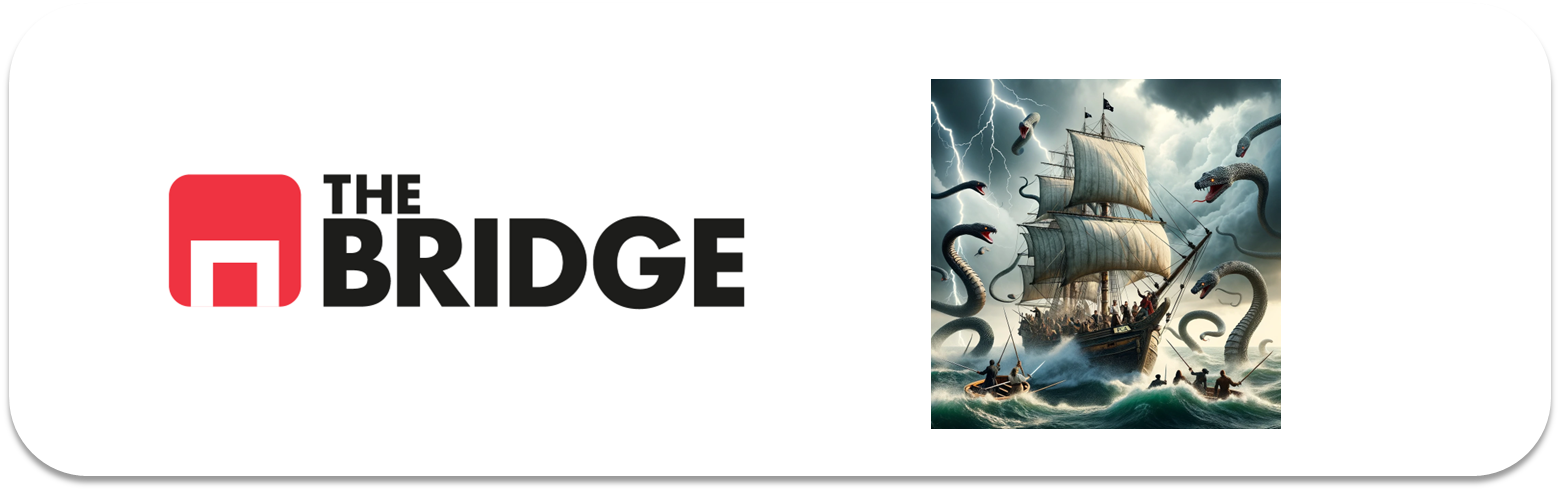

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

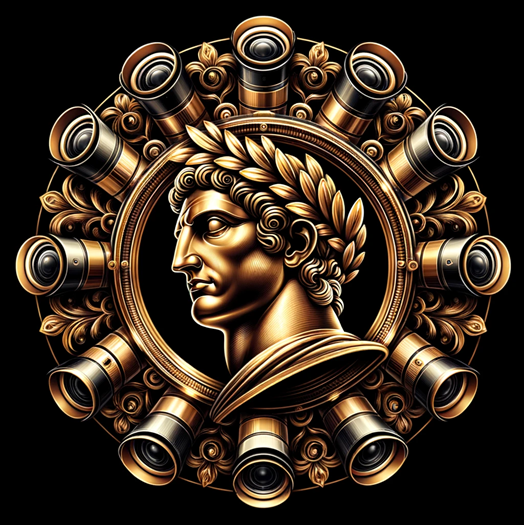

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

# Descargar el dataset de caras de Olivetti
olivetti = fetch_olivetti_faces()
X = olivetti.data  # Imágenes
y = olivetti.target  # Etiquetas

# Crear un DataFrame con los datos y etiquetas
df = pd.DataFrame(X)
df['target'] = y

# Mostrar información del DataFrame
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 4097 entries, 0 to target
dtypes: float32(4096), int32(1)
memory usage: 6.3 MB
None
          0         1         2         3         4         5         6  \
0  0.309917  0.367769  0.417355  0.442149  0.528926  0.607438  0.657025   
1  0.454545  0.471074  0.512397  0.557851  0.595041  0.640496  0.681818   
2  0.318182  0.400826  0.491736  0.528926  0.586777  0.657025  0.681818   
3  0.198347  0.194215  0.194215  0.194215  0.190083  0.190083  0.243802   
4  0.500000  0.545455  0.582645  0.623967  0.648760  0.690083  0.694215   

          7         8         9  ...      4087      4088      4089      4090  \
0  0.677686  0.690083  0.685950  ...  0.669421  0.652893  0.661157  0.475207   
1  0.702479  0.710744  0.702479  ...  0.157025  0.136364  0.148760  0.152893   
2  0.685950  0.702479  0.698347  ...  0.132231  0.181818  0.136364  0.128099   
3  0.404959  0.483471  0.516529  ...  0.636364  0.657025  0.6859

In [2]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en entrenamiento y prueba con 80 instancias en el test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=80, stratify=y, random_state=42
)

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}')


Tamaño del conjunto de entrenamiento: (320, 4096)
Tamaño del conjunto de prueba: (80, 4096)


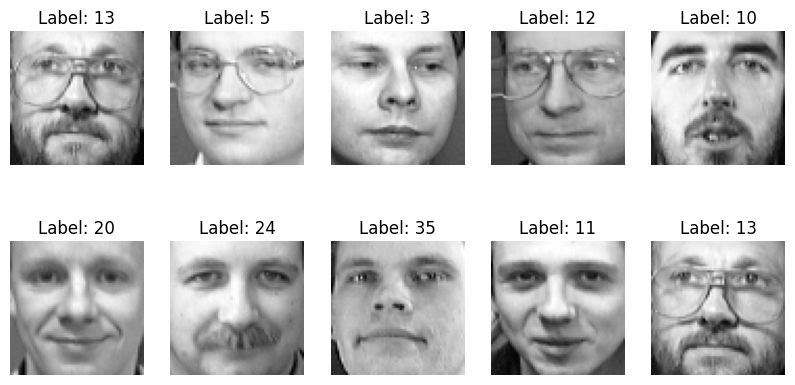

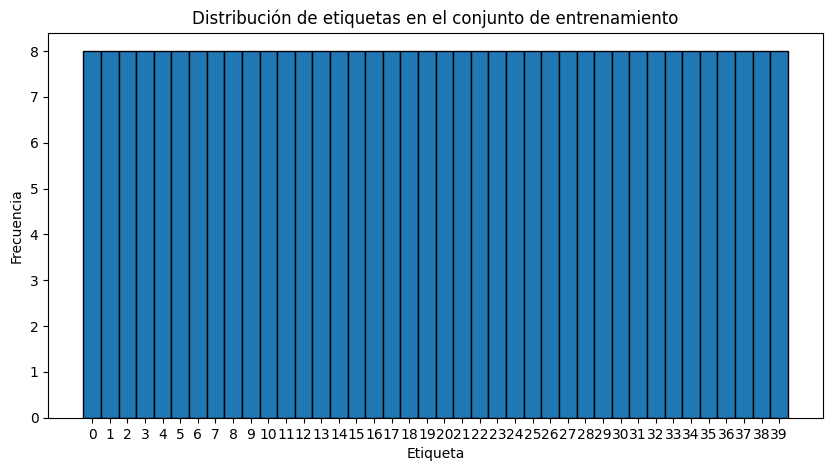

In [3]:
# Mostrar algunas imágenes del dataset
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i].reshape(64, 64), cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.show()

# Mostrar la distribución de las etiquetas
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=np.arange(41) - 0.5, edgecolor='black')
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.title('Distribución de etiquetas en el conjunto de entrenamiento')
plt.xticks(np.arange(40))
plt.show()


In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score

# Crear el modelo SVM
clf = SVC(kernel='linear', random_state=42)

# Validación cruzada con 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='balanced_accuracy')

# Entrenar el modelo en el conjunto de entrenamiento
clf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_test = clf.predict(X_test)

# Medir la balanced accuracy en el conjunto de prueba
test_score = balanced_accuracy_score(y_test, y_pred_test)

# Resultados
print(f'Balanced Accuracy en validación cruzada (5 folds): {cv_scores.mean():.2f} ± {cv_scores.std():.2f}')
print(f'Balanced Accuracy en el conjunto de prueba: {test_score:.2f}')


Balanced Accuracy en validación cruzada (5 folds): 0.97 ± 0.03
Balanced Accuracy en el conjunto de prueba: 0.97


### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [5]:
from sklearn.decomposition import PCA

# Instanciar PCA sin especificar componentes ni varianza explicada
pca = PCA()
pca.fit(X_train)


PCA()

In [6]:
# Calcular el rango de valores para el número de componentes principales
total_pixels = X_train.shape[1]
compression_ratios = np.array([0.002, 0.005, 0.01, 0.015, 0.025])
num_components = (total_pixels * compression_ratios).astype(int)

print(f'Rango de valores para el número de componentes principales: {num_components}')


Rango de valores para el número de componentes principales: [  8  20  40  61 102]


In [7]:
# Crear un DataFrame para almacenar los resultados
results = []

for n in num_components:
    # Aplicar PCA con n componentes principales
    pca = PCA(n_components=n, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Entrenar y evaluar el modelo SVM
    clf_pca = SVC(kernel='linear', random_state=42)
    cv_scores_pca = cross_val_score(clf_pca, X_train_pca, y_train, cv=5, scoring='balanced_accuracy')
    clf_pca.fit(X_train_pca, y_train)
    y_pred_test_pca = clf_pca.predict(X_test_pca)
    test_score_pca = balanced_accuracy_score(y_test, y_pred_test_pca)
    
    # Calcular el porcentaje de compresión
    compression_percentage = (n / total_pixels) * 100
    
    # Guardar los resultados
    results.append({
        'num_components': n,
        'cv_score_mean': cv_scores_pca.mean(),
        'cv_score_std': cv_scores_pca.std(),
        'test_score': test_score_pca,
        'compression_percentage': compression_percentage,
        'cv_score_diff': cv_scores_pca.mean() - 0.97,  # Diferencia con el baseline CV
        'test_score_diff': test_score_pca - 0.97  # Diferencia con el baseline test
    })

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Mostrar el DataFrame con los resultados
print(results_df)


   num_components  cv_score_mean  cv_score_std  test_score  \
0               8         0.8075      0.054544      0.8250   
1              20         0.9500      0.017678      0.9375   
2              40         0.9575      0.020310      0.9625   
3              61         0.9575      0.020310      0.9750   
4             102         0.9600      0.016583      0.9750   

   compression_percentage  cv_score_diff  test_score_diff  
0                0.195312        -0.1625          -0.1450  
1                0.488281        -0.0200          -0.0325  
2                0.976562        -0.0125          -0.0075  
3                1.489258        -0.0125           0.0050  
4                2.490234        -0.0100           0.0050  


In [8]:
# Filtrar los resultados con pérdida inferior a 3 puntos porcentuales
filtered_results = results_df[(results_df['cv_score_diff'] >= -0.03) & (results_df['test_score_diff'] >= -0.03)]

if filtered_results.empty:
    # Si no hay resultados con pérdida inferior a 3 puntos porcentuales, filtrar por 5 puntos
    filtered_results = results_df[(results_df['cv_score_diff'] >= -0.05) & (results_df['test_score_diff'] >= -0.05)]

# Seleccionar el resultado con mayor compresión
optimal_result = filtered_results.loc[filtered_results['compression_percentage'].idxmax()]

print(f'Número óptimo de componentes: {optimal_result["num_components"]}')
print(f'Balanced Accuracy en CV: {optimal_result["cv_score_mean"]:.2f} ± {optimal_result["cv_score_std"]:.2f}')
print(f'Balanced Accuracy en el conjunto de prueba: {optimal_result["test_score"]:.2f}')
print(f'Porcentaje de compresión: {optimal_result["compression_percentage"]:.2f}%')
print(f'Diferencia con el scoring de CV del modelo baseline: {optimal_result["cv_score_diff"]:.2f}')
print(f'Diferencia con el scoring en test del modelo baseline: {optimal_result["test_score_diff"]:.2f}')


Número óptimo de componentes: 102.0
Balanced Accuracy en CV: 0.96 ± 0.02
Balanced Accuracy en el conjunto de prueba: 0.97
Porcentaje de compresión: 2.49%
Diferencia con el scoring de CV del modelo baseline: -0.01
Diferencia con el scoring en test del modelo baseline: 0.01


### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

   num_components  cv_score_mean  cv_score_std  test_score  \
0               4         0.6025      0.045689      0.5250   
1               8         0.8075      0.054544      0.8250   
2              16         0.9350      0.012247      0.9375   
3              32         0.9550      0.010000      0.9625   
4              64         0.9575      0.020310      0.9750   

   compression_percentage  cv_score_diff  test_score_diff  
0                0.097656        -0.3675          -0.4450  
1                0.195312        -0.1625          -0.1450  
2                0.390625        -0.0350          -0.0325  
3                0.781250        -0.0150          -0.0075  
4                1.562500        -0.0125           0.0050  


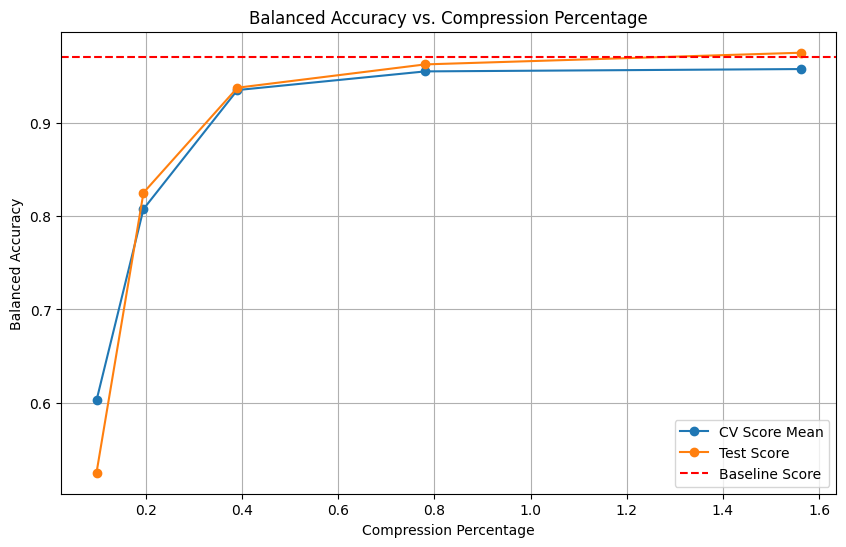

Número óptimo de componentes: 64.0
Balanced Accuracy en CV: 0.96 ± 0.02
Balanced Accuracy en el conjunto de prueba: 0.97
Porcentaje de compresión: 1.56%
Diferencia con el scoring de CV del modelo baseline: -0.01
Diferencia con el scoring en test del modelo baseline: 0.01


In [9]:
# Cargar el dataset de caras de Olivetti
data = fetch_olivetti_faces()
X, y = data['data'], data['target']

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Número total de píxeles en las imágenes
total_pixels = X_train.shape[1]

# Rango de componentes principales para compresión entre 0.1% y 1%
num_components = [4, 8, 16, 32, 64]

# Crear un DataFrame para almacenar los resultados
results = []

for n in num_components:
    # Aplicar PCA con n componentes principales
    pca = PCA(n_components=n, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Descomprimir las imágenes aplicando la inversa de PCA
    X_train_unzipped = pca.inverse_transform(X_train_pca)
    X_test_unzipped = pca.inverse_transform(X_test_pca)
    
    # Entrenar y evaluar el modelo SVM
    clf = SVC(kernel='linear', random_state=42)
    cv_scores = cross_val_score(clf, X_train_unzipped, y_train, cv=5, scoring='balanced_accuracy')
    clf.fit(X_train_unzipped, y_train)
    y_pred_test = clf.predict(X_test_unzipped)
    test_score = balanced_accuracy_score(y_test, y_pred_test)
    
    # Calcular el porcentaje de compresión
    compression_percentage = (n / total_pixels) * 100
    
    # Guardar los resultados
    results.append({
        'num_components': n,
        'cv_score_mean': cv_scores.mean(),
        'cv_score_std': cv_scores.std(),
        'test_score': test_score,
        'compression_percentage': compression_percentage,
        'cv_score_diff': cv_scores.mean() - 0.97,  # Diferencia con el baseline CV
        'test_score_diff': test_score - 0.97  # Diferencia con el baseline test
    })

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Mostrar los resultados
print(results_df)

# Visualización de los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['compression_percentage'], results_df['cv_score_mean'], marker='o', label='CV Score Mean')
plt.plot(results_df['compression_percentage'], results_df['test_score'], marker='o', label='Test Score')
plt.axhline(y=0.97, color='r', linestyle='--', label='Baseline Score')
plt.xlabel('Compression Percentage')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs. Compression Percentage')
plt.legend()
plt.grid(True)
plt.show()

# Selección del número de componentes basado en la pérdida de precisión aceptable
acceptable_loss = 0.03
filtered_results = results_df[(results_df['cv_score_diff'] >= -acceptable_loss) & (results_df['test_score_diff'] >= -acceptable_loss)]

if filtered_results.empty:
    acceptable_loss = 0.05
    filtered_results = results_df[(results_df['cv_score_diff'] >= -acceptable_loss) & (results_df['test_score_diff'] >= -acceptable_loss)]

optimal_result = filtered_results.loc[filtered_results['compression_percentage'].idxmax()]

# Mostrar el resultado óptimo
print(f'Número óptimo de componentes: {optimal_result["num_components"]}')
print(f'Balanced Accuracy en CV: {optimal_result["cv_score_mean"]:.2f} ± {optimal_result["cv_score_std"]:.2f}')
print(f'Balanced Accuracy en el conjunto de prueba: {optimal_result["test_score"]:.2f}')
print(f'Porcentaje de compresión: {optimal_result["compression_percentage"]:.2f}%')
print(f'Diferencia con el scoring de CV del modelo baseline: {optimal_result["cv_score_diff"]:.2f}')
print(f'Diferencia con el scoring en test del modelo baseline: {optimal_result["test_score_diff"]:.2f}')


### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

Visualización de las dos primeras componentes principales
Primero, visualicemos las dos primeras componentes principales de la PCA utilizando los componentes seleccionados (102 en este caso). Haremos scatter plots con cada clase coloreada para facilitar la interpretación visual

C:\Users\ferna\AppData\Local\Temp\ipykernel_4796\4131545539.py:10: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=sns.color_palette("hsv", end_class - start_class + 1), legend='full')


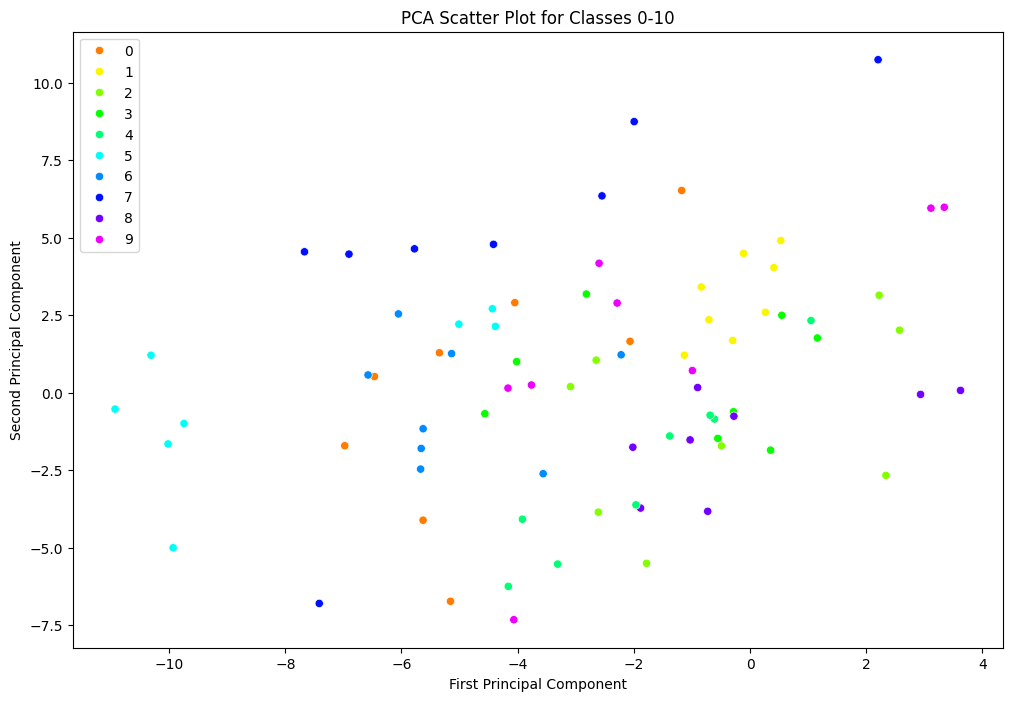

C:\Users\ferna\AppData\Local\Temp\ipykernel_4796\4131545539.py:10: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=sns.color_palette("hsv", end_class - start_class + 1), legend='full')


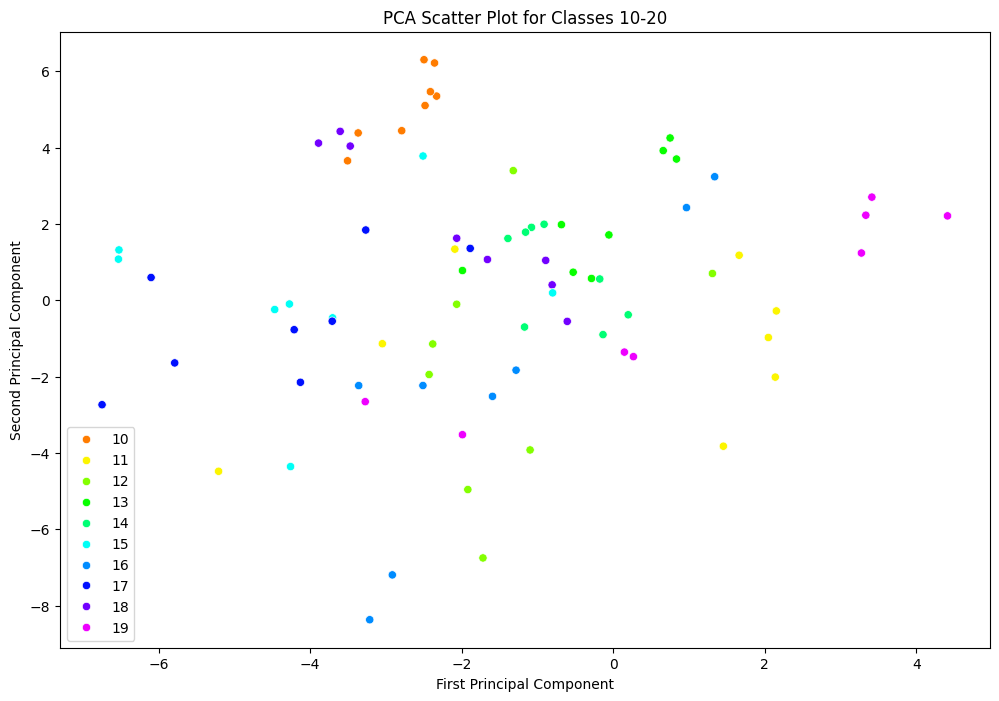

C:\Users\ferna\AppData\Local\Temp\ipykernel_4796\4131545539.py:10: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=sns.color_palette("hsv", end_class - start_class + 1), legend='full')


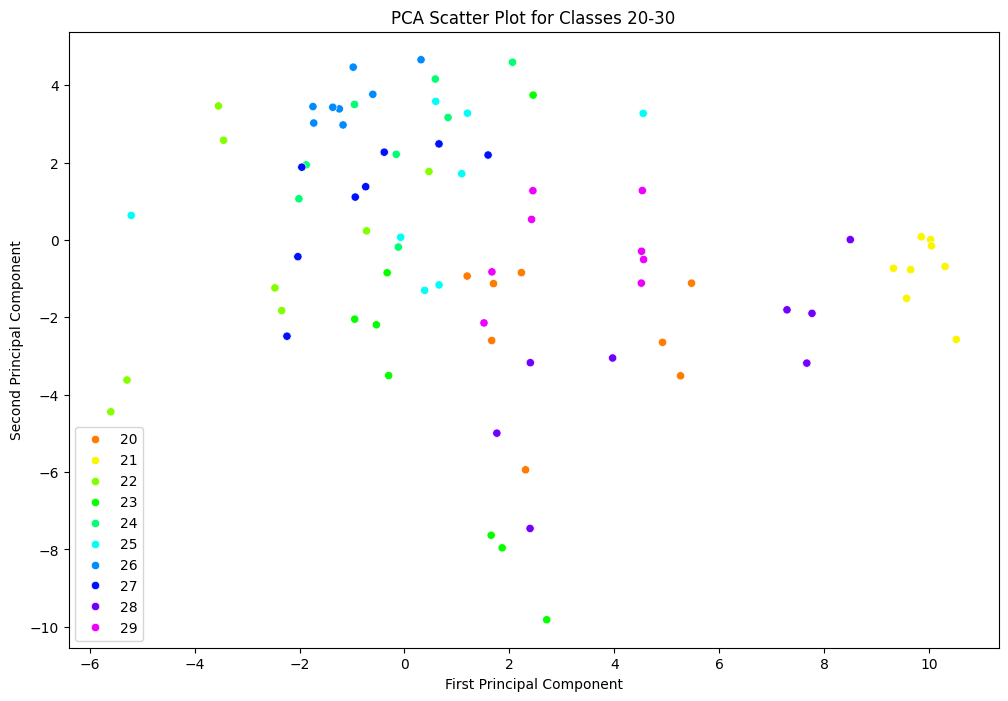

C:\Users\ferna\AppData\Local\Temp\ipykernel_4796\4131545539.py:10: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=sns.color_palette("hsv", end_class - start_class + 1), legend='full')


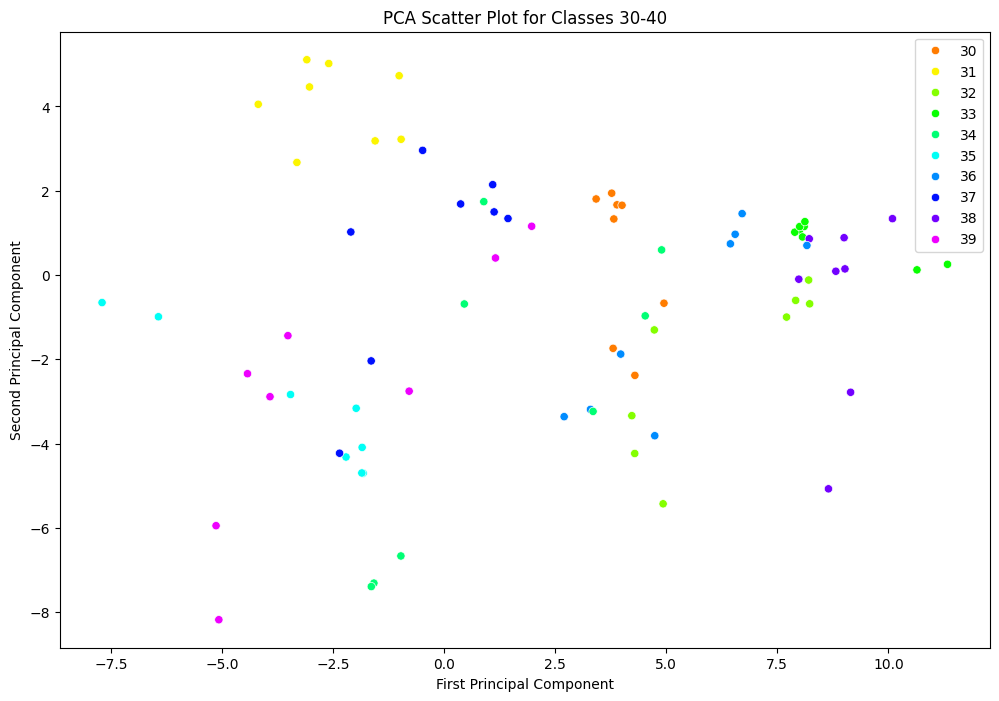

In [10]:
import seaborn as sns

# Aplicar PCA con el número óptimo de componentes (102)
pca_optimal = PCA(n_components=102, random_state=42)
X_train_pca_optimal = pca_optimal.fit_transform(X_train)

# Scatter plot de las dos primeras componentes principales coloreadas por clase
def plot_pca_scatter(X_pca, y, start_class, end_class):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=sns.color_palette("hsv", end_class - start_class + 1), legend='full')
    plt.title(f'PCA Scatter Plot for Classes {start_class}-{end_class}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

# Plotear los gráficos para las clases 1-10, 11-20, 21-30 y 31-40
for i in range(0, 40, 10):
    mask = (y_train >= i) & (y_train < i + 10)
    plot_pca_scatter(X_train_pca_optimal[mask], y_train[mask], i, i + 10)


Visualización de las caras antes y después de la compresión
Vamos a definir una función para visualizar las caras originales y las caras después de ser comprimidas y descomprimidas utilizando diferentes números de componentes principales. Además, incluimos los casos de 150 y 300 componentes para ver la diferencia en la calidad de reconstrucción.

Visualizando caras comprimidas y descomprimidas con 4 componentes principales


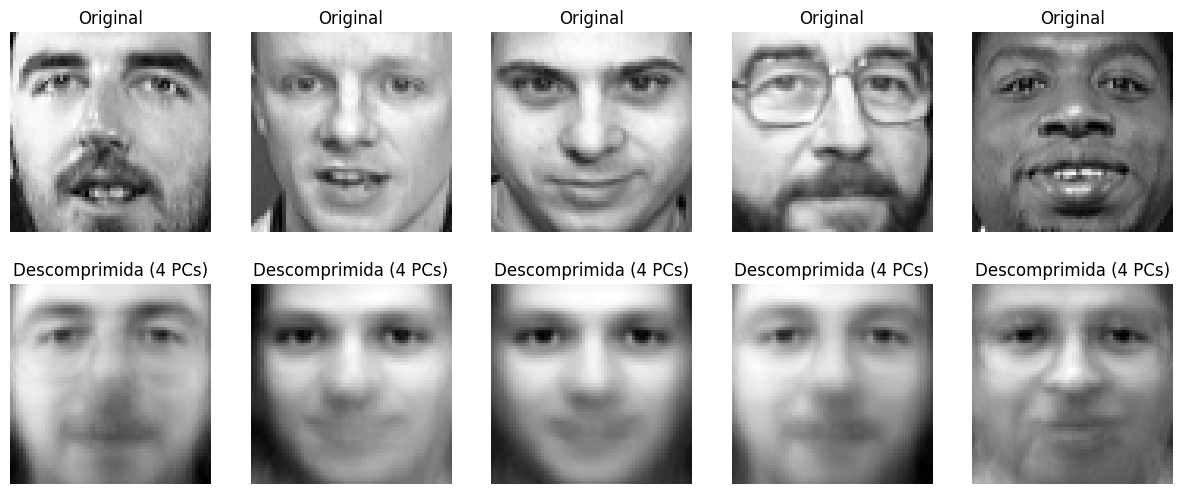

Visualizando caras comprimidas y descomprimidas con 8 componentes principales


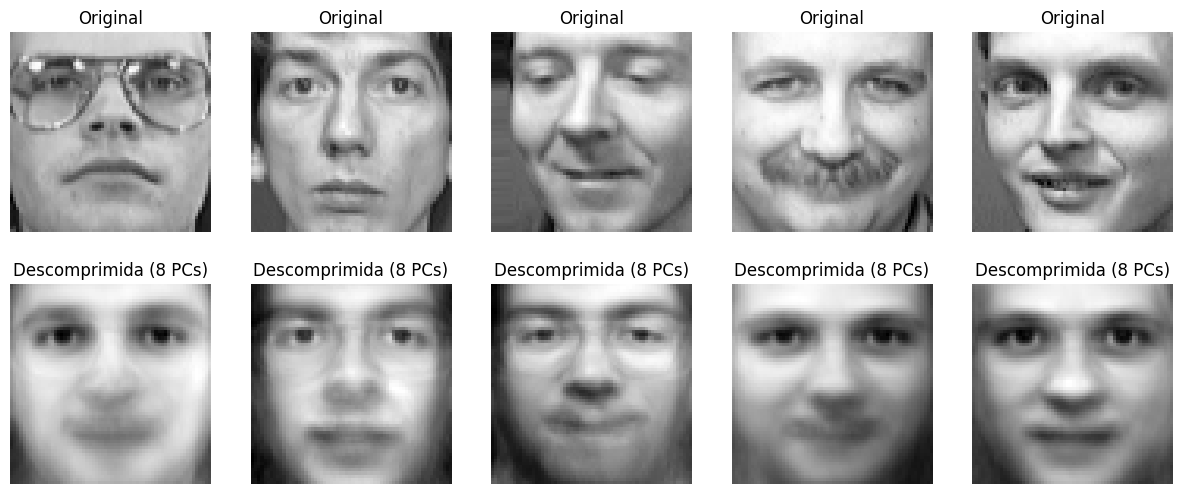

Visualizando caras comprimidas y descomprimidas con 16 componentes principales


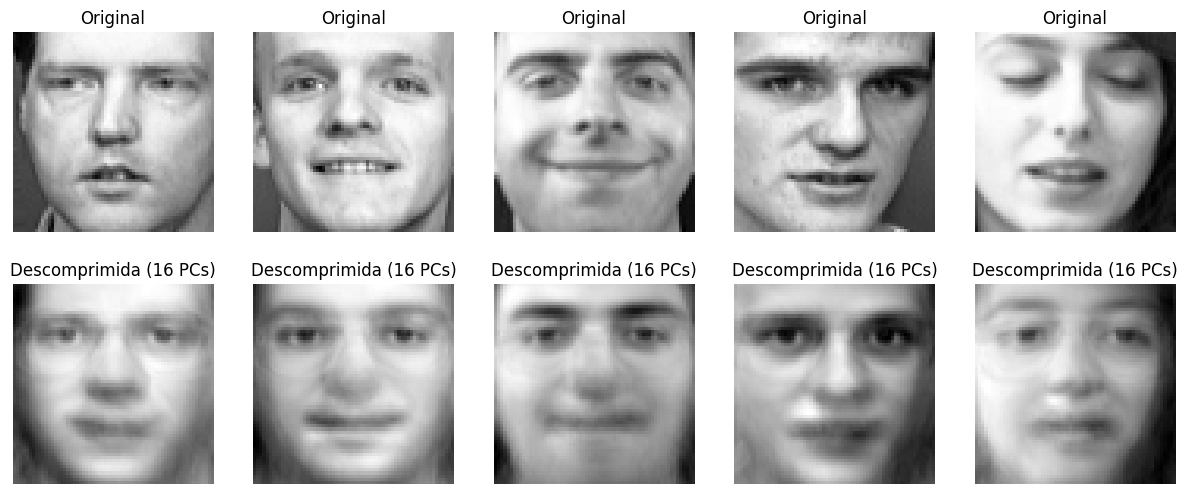

Visualizando caras comprimidas y descomprimidas con 32 componentes principales


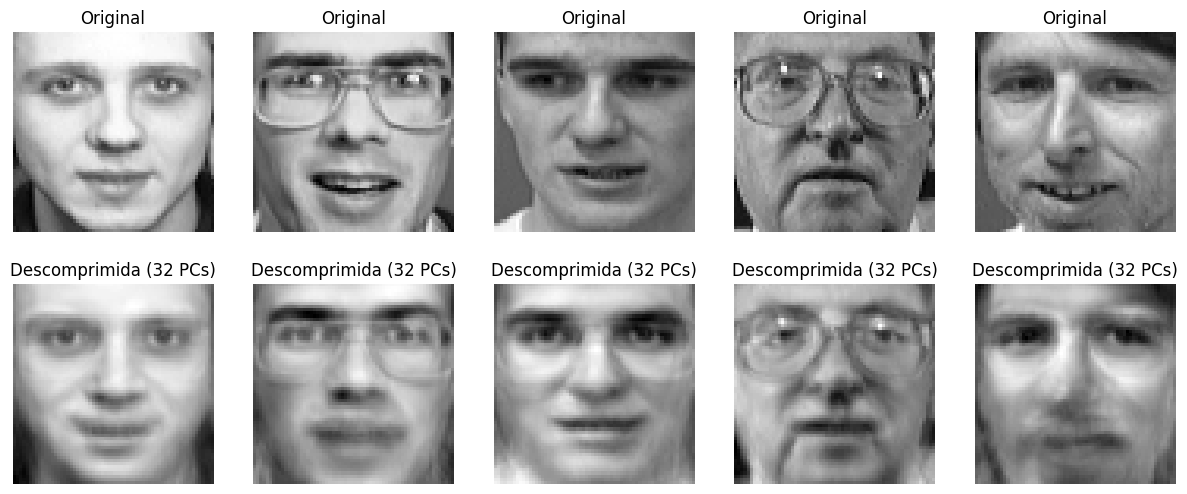

Visualizando caras comprimidas y descomprimidas con 64 componentes principales


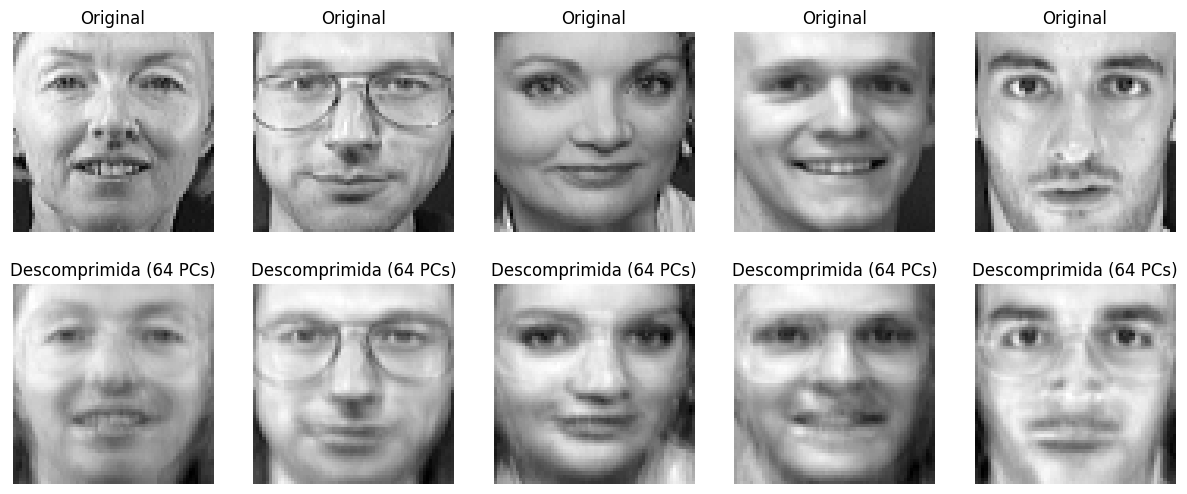

Visualizando caras comprimidas y descomprimidas con 150 componentes principales


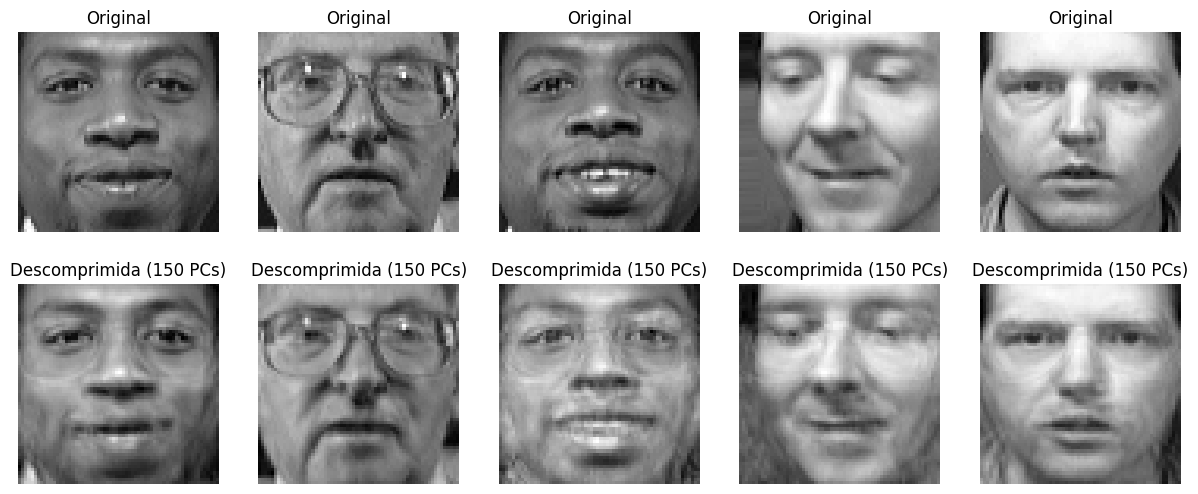

Visualizando caras comprimidas y descomprimidas con 300 componentes principales


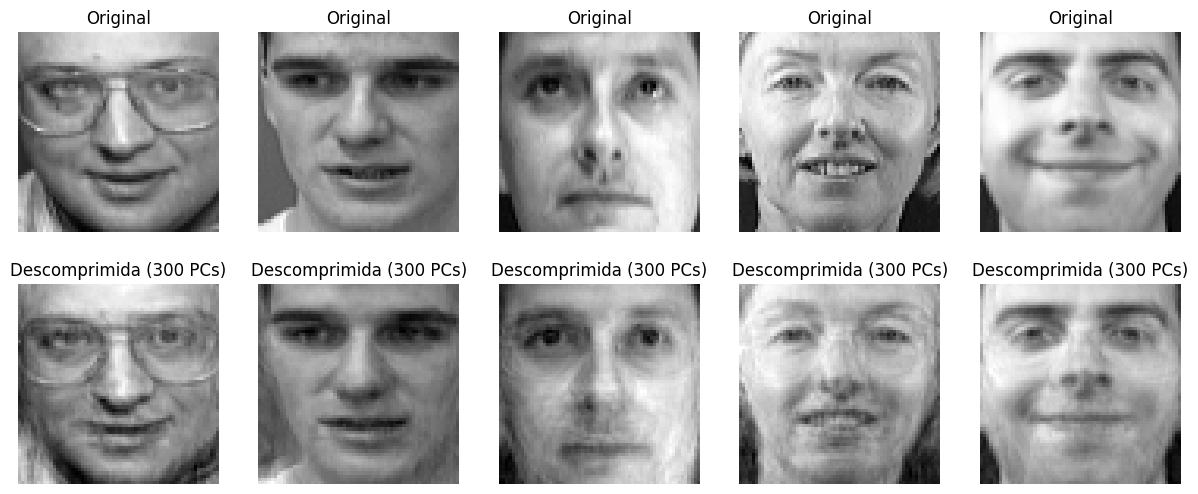

In [11]:
def plot_compressed_faces(X, pca, num_faces=5):
    # Seleccionar aleatoriamente algunas caras para visualizar
    idx = np.random.choice(X.shape[0], num_faces, replace=False)
    faces = X[idx]
    
    # Comprimir y descomprimir las caras
    faces_compressed = pca.transform(faces)
    faces_unzipped = pca.inverse_transform(faces_compressed)
    
    plt.figure(figsize=(15, 6))
    
    for i in range(num_faces):
        # Cara original
        ax = plt.subplot(2, num_faces, i + 1)
        plt.imshow(faces[i].reshape(64, 64), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # Cara descomprimida
        ax = plt.subplot(2, num_faces, i + 1 + num_faces)
        plt.imshow(faces_unzipped[i].reshape(64, 64), cmap='gray')
        plt.title(f"Descomprimida ({pca.n_components_} PCs)")
        plt.axis('off')
    
    plt.show()

# Números de componentes a probar
num_components_to_test = [4, 8, 16, 32, 64, 150, 300]

# Visualizar las caras para cada número de componentes
for n in num_components_to_test:
    pca_test = PCA(n_components=n, random_state=42)
    pca_test.fit(X_train)
    print(f"Visualizando caras comprimidas y descomprimidas con {n} componentes principales")
    plot_compressed_faces(X_test, pca_test)
